# Transfer Learning
**Transfer learning** is a technique where a pre-trained model, trained on a large dataset, is reused on a new, often smaller dataset. The idea is to leverage the knowledge (features) the model has already learned and fine-tune it for the specific task. This approach speeds up training and improves performance, especially when limited data is available for the new task.
## 1. Load the Data

In [3]:
import torch
import torch.nn as nn
import  torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os

In [4]:
!wget -P data https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2025-04-06 16:46:32--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.186.12, 2600:1409:3c00:688::317f, 2600:1409:3c00:681::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.218.186.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘data/kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   176MB/s    in 6.9s    

2025-04-06 16:46:39 (114 MB/s) - ‘data/kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [5]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [6]:
import os
import glob

def check_image_dir(dir_path):
    """
    Checks the specified directory for image files and prints information about them.

    Args:
    dir_path (str): The path to the directory containing images.
    """
    image_files = glob.glob(dir_path)
    num_images = len(image_files)

    print(f"Found {num_images} images in directory: {dir_path}")


# Existing code calling check_image_dir:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Found 12500 images in directory: data/PetImages/Cat/*.jpg
Found 12500 images in directory: data/PetImages/Dog/*.jpg


In [7]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])

trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        std_normalize])

In [8]:
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])


## 2. Visualize the Dataset

In [9]:
import matplotlib.pyplot as plt

def display_dataset(dataset, num_images=5):
    """
    Displays a few images from the dataset.

    Args:
    dataset (torch.utils.data.Dataset): The dataset to display images from.
    num_images (int, optional): The number of images to display. Defaults to 5.
    """


    indices = np.random.choice(len(dataset), num_images, replace=False)


    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))


    for i, index in enumerate(indices):
        image, label = dataset[index]

        # Convert the image to numpy and transpose for display
        image = image.numpy().transpose((1, 2, 0))


        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')

    plt.show()

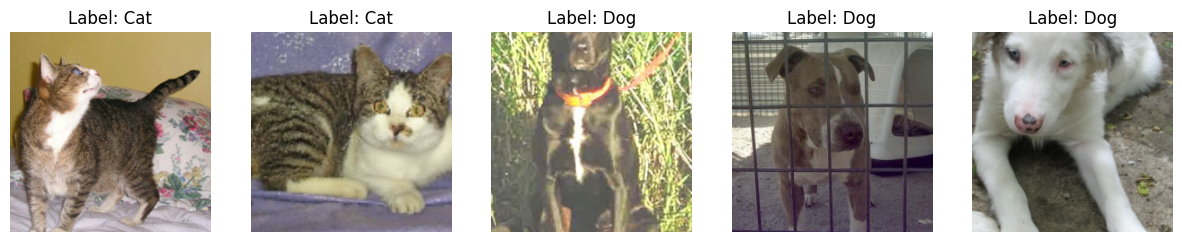

In [10]:
display_dataset(dataset)

## 3. Using Pre-trained Models

In [11]:
vgg16 = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
result = vgg16(sample_image)
print(result[0].argmax())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 169MB/s]


tensor(282)


In [12]:
import json, requests
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[result[0].argmax().item()]

['n02123159', 'tiger_cat']

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg16.to(device)
sample_image = sample_image.to(device)

vgg16(sample_image).argmax()

Doing computations on device = cuda


tensor(281, device='cuda:0')

In [14]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg16 = vgg16.to(device)

summary(vgg16, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## 4. Extracting VGG Features

torch.Size([1, 512, 7, 7])


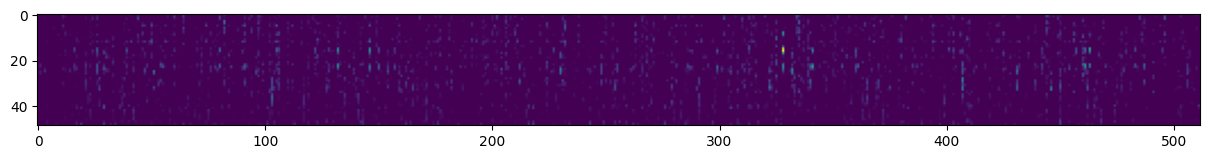

In [15]:
res = vgg16.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(512,-1).T)
print(res.size())

In [16]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg16.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break

....................................................................................................

## 5. Train Model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the train function
def train(model, train_loader, test_loader, epochs):
    """
    Trains the given model on the training data and evaluates it on the test data.

    Args:
        model: The neural network model to train.
        train_loader: DataLoader for the training dataset.
        test_loader: DataLoader for the test dataset.
        epochs: Number of training epochs.

    Returns:
        A dictionary containing the training and test losses and accuracies for each epoch.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Store the training history
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_samples = 0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training")):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == target).sum().item()
            total_samples += target.size(0)


        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / total_samples
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        total_samples = 0

        with torch.no_grad():
            for data, target in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Testing"):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_correct += (predicted == target).sum().item()
                total_samples += target.size(0)

        avg_test_loss = test_loss / len(test_loader)
        test_acc = test_correct / total_samples
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return history

In [18]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader,epochs=10)

Epoch 1/10 - Training:   0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 1/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 1184.16it/s]


Epoch 1/10 - Train Loss: 0.4356, Train Acc: 0.8971, Test Loss: 0.2067, Test Acc: 0.9500


Epoch 2/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 1178.01it/s]


Epoch 2/10 - Train Loss: 0.0237, Train Acc: 0.9929, Test Loss: 0.5453, Test Acc: 0.9400


Epoch 3/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 1169.06it/s]


Epoch 3/10 - Train Loss: 0.0096, Train Acc: 0.9957, Test Loss: 0.2869, Test Acc: 0.9500


Epoch 4/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 680.40it/s]


Epoch 4/10 - Train Loss: 0.0003, Train Acc: 1.0000, Test Loss: 0.2948, Test Acc: 0.9500


Epoch 5/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 1110.78it/s]


Epoch 5/10 - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 0.3300, Test Acc: 0.9500


Epoch 6/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 1110.34it/s]


Epoch 6/10 - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 0.3503, Test Acc: 0.9500


Epoch 7/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 1139.91it/s]


Epoch 7/10 - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 0.3643, Test Acc: 0.9400


Epoch 8/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 1058.63it/s]


Epoch 8/10 - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.3752, Test Acc: 0.9400


Epoch 9/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 628.60it/s]


Epoch 9/10 - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.3841, Test Acc: 0.9400


Epoch 10/10 - Testing: 100%|██████████| 4/4 [00:00<00:00, 896.36it/s]

Epoch 10/10 - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.3917, Test Acc: 0.9400


## Transfer Learning

In [19]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
vgg16.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg16.features.parameters():
    x.requires_grad = False

summary(vgg16, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [27]:
import os
import torch
import torch.optim as optim
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError

def validate_dataset(dataset):
    """
    Validate all images in a dataset and return valid indices
    """
    valid_indices = []
    corrupted_indices = []

    print("Validating dataset images...")
    for idx in tqdm(range(len(dataset))):
        try:
            # Access the image path - this depends on your dataset's structure
            if hasattr(dataset, 'samples'):
                img_path = dataset.samples[idx][0]
            elif hasattr(dataset, 'imgs'):
                img_path = dataset.imgs[idx][0]
            elif hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'samples'):
                # For datasets created with random_split
                img_path = dataset.dataset.samples[dataset.indices[idx]][0]
            else:
                # Skip validation if we can't determine the path
                valid_indices.append(idx)
                continue

            # Validate the image
            with Image.open(img_path) as img:
                img.verify()
                # Try to convert to RGB to catch additional issues
                with Image.open(img_path) as img_rgb:
                    img_rgb.convert('RGB')
                valid_indices.append(idx)
        except (UnidentifiedImageError, OSError, FileNotFoundError, AttributeError) as e:
            print(f"Corrupted image detected at index {idx}: {e}")
            corrupted_indices.append(idx)

    print(f"Found {len(valid_indices)} valid images")
    print(f"Found {len(corrupted_indices)} corrupted images")

    return valid_indices, corrupted_indices

In [29]:
def create_valid_dataloaders(dataset, batch_size=16, train_size=20000):
    """
    Create train and test dataloaders using only valid images
    """

    valid_indices, _ = validate_dataset(dataset)

    # Use only valid indices for splitting
    if train_size > len(valid_indices):
        train_size = len(valid_indices) // 2

    # Random split of valid indices
    train_indices = valid_indices[:train_size]
    test_indices = valid_indices[train_size:]

    # Create subset samplers
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    # Create dataloaders with samplers
    train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=train_sampler
    )

    test_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=test_sampler
    )

    return train_loader, test_loader


In [38]:
def train_long(model, train_loader, test_loader, loss_fn, epochs, print_freq=90,lr=0.001):
    """
    Trains the given model on the training data and evaluates it on the test data.
    """
    optimizer = optim.Adam(model.parameters(),lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {'test_loss': [], 'test_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training")):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % print_freq == print_freq - 1:
                print(f"[{epoch + 1}, {batch_idx + 1}] loss: {running_loss / print_freq:.3f}")
                running_loss = 0.0

        # Testing Phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        total_samples = 0

        with torch.no_grad():
            for data, target in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Testing"):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = loss_fn(output, target)
                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_correct += (predicted == target).sum().item()
                total_samples += target.size(0)

        avg_test_loss = test_loss / len(test_loader)
        test_acc = test_correct / total_samples
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch + 1}/{epochs} - Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return history

train_loader, test_loader = create_valid_dataloaders(dataset, batch_size=16, train_size=20000)


train_long(vgg16, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90)

Validating dataset images...


 36%|███▌      | 8916/25000 [00:10<00:19, 820.05it/s]

Corrupted image detected at index 8790: cannot identify image file 'data/PetImages/Cat/666.jpg'


 58%|█████▊    | 14499/25000 [00:17<00:12, 830.87it/s]

Corrupted image detected at index 14395: cannot identify image file 'data/PetImages/Dog/11702.jpg'


 96%|█████████▌| 23904/25000 [00:29<00:01, 832.31it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 25000/25000 [00:31<00:00, 803.02it/s]


Found 24998 valid images
Found 2 corrupted images


Epoch 1/1 - Training:   7%|▋         | 90/1250 [00:24<05:10,  3.73it/s]

[1, 90] loss: 1.233


Epoch 1/1 - Training:  14%|█▍        | 180/1250 [00:49<04:46,  3.74it/s]

[1, 180] loss: 0.684


Epoch 1/1 - Training:  22%|██▏       | 270/1250 [01:13<04:29,  3.64it/s]

[1, 270] loss: 0.675


Epoch 1/1 - Training:  29%|██▉       | 360/1250 [01:38<04:13,  3.51it/s]

[1, 360] loss: 0.669


Epoch 1/1 - Training:  36%|███▌      | 450/1250 [02:02<03:55,  3.40it/s]

[1, 450] loss: 0.666


Epoch 1/1 - Training:  43%|████▎     | 540/1250 [02:27<03:28,  3.41it/s]

[1, 540] loss: 0.665


Epoch 1/1 - Training:  50%|█████     | 630/1250 [02:51<03:02,  3.41it/s]

[1, 630] loss: 0.661


Epoch 1/1 - Training:  58%|█████▊    | 720/1250 [03:16<02:27,  3.60it/s]

[1, 720] loss: 0.657


Epoch 1/1 - Training:  65%|██████▍   | 810/1250 [03:40<02:01,  3.63it/s]

[1, 810] loss: 0.659


Epoch 1/1 - Training:  72%|███████▏  | 900/1250 [04:05<01:35,  3.67it/s]

[1, 900] loss: 0.682


Epoch 1/1 - Training:  79%|███████▉  | 990/1250 [04:29<01:10,  3.69it/s]

[1, 990] loss: 0.662


Epoch 1/1 - Training:  86%|████████▋ | 1080/1250 [04:53<00:45,  3.74it/s]

[1, 1080] loss: 0.666


Epoch 1/1 - Training:  94%|█████████▎| 1170/1250 [05:18<00:21,  3.70it/s]

[1, 1170] loss: 0.661


Epoch 1/1 - Testing: 100%|██████████| 313/313 [00:42<00:00,  7.36it/s]

Epoch 1/1 - Test Loss: 0.9729, Test Acc: 0.0000


{'test_loss': [0.9728993773460388], 'test_acc': [0.0]}

In [39]:
torch.save(vgg16,'data/cats_dogs.pth')

In [40]:
import torch

# Load the model with weights_only=False
vgg16 = torch.load('data/cats_dogs.pth', weights_only=False)

In [41]:
for x in vgg16.features.parameters():
    x.requires_grad = True

## Fine-tuning transfer learning

In [43]:
train_long(vgg16,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.001)


Epoch 1/1 - Training:   7%|▋         | 90/1250 [00:24<05:13,  3.70it/s]

[1, 90] loss: 0.660


Epoch 1/1 - Training:  14%|█▍        | 180/1250 [00:48<04:50,  3.69it/s]

[1, 180] loss: 0.660


Epoch 1/1 - Training:  22%|██▏       | 270/1250 [01:13<05:10,  3.15it/s]

[1, 270] loss: 0.669


Epoch 1/1 - Training:  29%|██▉       | 360/1250 [01:38<03:58,  3.73it/s]

[1, 360] loss: 0.663


Epoch 1/1 - Training:  36%|███▌      | 450/1250 [02:02<03:32,  3.76it/s]

[1, 450] loss: 0.671


Epoch 1/1 - Training:  43%|████▎     | 540/1250 [02:27<03:09,  3.75it/s]

[1, 540] loss: 0.668


Epoch 1/1 - Training:  50%|█████     | 630/1250 [02:51<02:44,  3.78it/s]

[1, 630] loss: 0.658


Epoch 1/1 - Training:  58%|█████▊    | 720/1250 [03:16<02:21,  3.73it/s]

[1, 720] loss: 0.664


Epoch 1/1 - Training:  65%|██████▍   | 810/1250 [03:40<01:56,  3.77it/s]

[1, 810] loss: 0.663


Epoch 1/1 - Training:  72%|███████▏  | 900/1250 [04:05<01:33,  3.75it/s]

[1, 900] loss: 0.658


Epoch 1/1 - Training:  79%|███████▉  | 990/1250 [04:29<01:09,  3.74it/s]

[1, 990] loss: 0.658


Epoch 1/1 - Training:  86%|████████▋ | 1080/1250 [04:54<00:45,  3.74it/s]

[1, 1080] loss: 0.656


Epoch 1/1 - Training:  94%|█████████▎| 1170/1250 [05:18<00:21,  3.74it/s]

[1, 1170] loss: 0.665


Epoch 1/1 - Testing:  69%|██████▊   | 215/313 [00:29<00:13,  7.11it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1/1 - Testing: 100%|██████████| 313/313 [00:42<00:00,  7.28it/s]

Epoch 1/1 - Test Loss: 1.0057, Test Acc: 0.0000


{'test_loss': [1.0056879528033467], 'test_acc': [0.0]}

In [44]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  